# Adding custom script to your ADF

Since individual scientists like to look at specific diagnostics, not every script can be brought in to the ADF. A handy option for your ADF package could be implementing your own custom scripts. This may not be a trivial process, but hopefully this example will help if you want to add your own scripts to your ADF.

This is not a required step if you have your own diagnostics, you could always keep them out of the ADF and run them post ADF. If this makes more sense, please see the ADF in Jupyter section.

For this demo, we will be taking an annual time series plotting script and adding it to the ADF infrastructure.

Time Series Plotting Script:

* don't be intimidated by the code...

This is meant to simulate what your external script may look like prior to incorporating into the ADF.

#### Setting up and running the script


  Generating time series plots...
	 - time series plot for TS
2001 2010


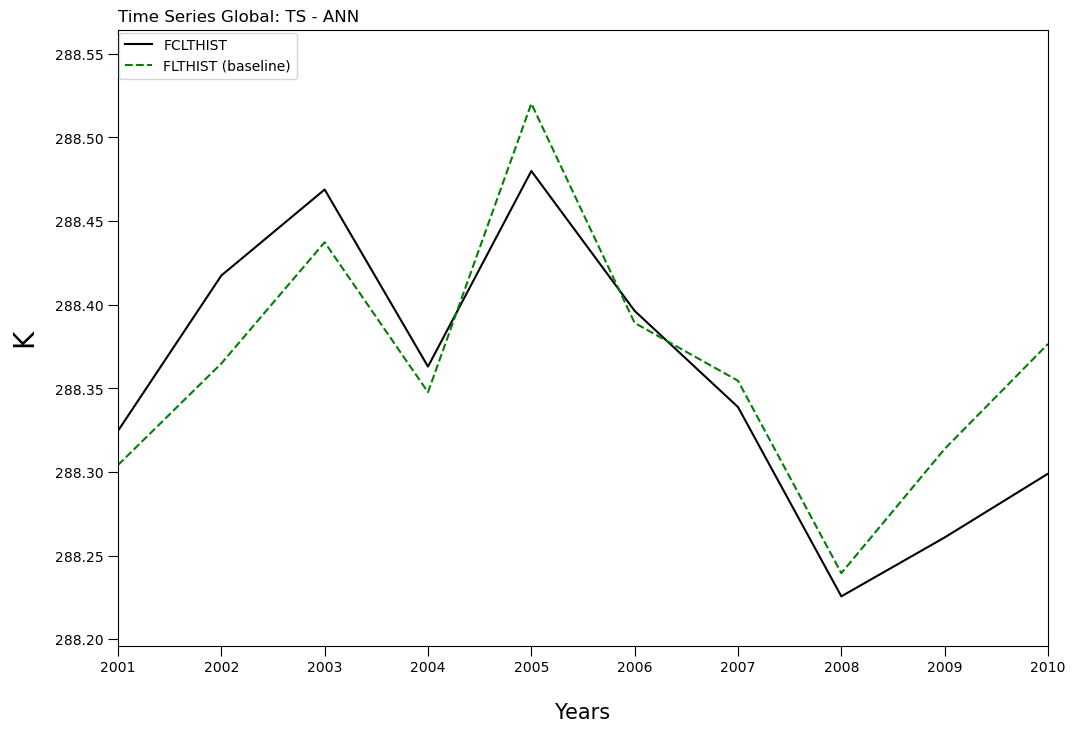

In [15]:
import os.path
import sys
import glob
from pathlib import Path

# Import necessary packages for the new script
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import xarray as xr


# Main plotting routine

def time_series(var_list, all_case_names, case_ts_locs, all_nicknames, plot_type):
    """
    This script plots time series.
    Compare CAM climatologies against other
    """

    #Notify user that script has started:
    print("\n  Generating time series plots...")
    
    # Get number of cases
    case_num = len(all_case_names)

    #ADF variable which contains the output path for plots and tables:
    plot_location = "./"
    plot_loc = Path(plot_location)


    #Set up the plots
    #################

    #Add more colors as needed for number of test cases
    #** Baseline is already added as green dashed line in plotting function **
    #matplotlib colors here: https://matplotlib.org/stable/gallery/color/named_colors.html
    colors = ["k", "aqua", "r", "b", "magenta",
              "orange", "slategrey", "rosybrown"]
    
    #Annual global weighted
    #######################
    season = "ANN"

    #Loop over variables:
    for var in var_list:
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)

        title_var = "Global"
        print(f"\t - time series plot for {var}")

        #Loop over test cases:
        #----------------------
        for case_idx, case_name in enumerate(all_case_names):
            if case_idx == 1:
                color_dict = {"color":'g',"marker":"--"}
            else:
                color_dict = {"color":colors[case_idx],"marker":"-"}
            #End if
            
            #Generate input file path:
            input_location = Path(case_ts_locs[case_idx])
            ts_filenames = f'{case_name}.*.{var}.*nc'
            ts_files = sorted(input_location.glob(ts_filenames))
            data = _load_data(ts_files[0], var)

            #Extract units string, if available:
            if hasattr(data, 'units'):
                unit_str = data.units
            else:
                unit_str = '--'

            #Check if variable has a vertical coordinate:
            if 'lev' in data.coords or 'ilev' in data.coords:
                print(f"\t   Variable '{var}' has a vertical dimension, "+\
                      "which is currently not supported for the AMWG Table. Skipping...")
                #Skip this variable and move to the next variable in var_list:
                continue
            #End if

            # we should check if we need to do area averaging:
            if len(data.dims) > 1:
                # flags that we have spatial dimensions
                # Note: that could be 'lev' which should trigger different behavior
                # Note: we should be able to handle (lat, lon) or (ncol,) cases, at least
                data = spatial_average(data)  # changes data "in place"

            #Get yearly averages for all available years
            vals_case = annual_mean(data, whole_years=True, time_name='time')

            #Get years for plotting on x-axis
            yrs = vals_case.year.values

            name = all_nicknames[case_idx]
            if case_idx == (case_num-1):
                name = f"{name} (baseline)"

            #Add case to plot (ax)
            ax.plot(yrs, vals_case, color_dict["marker"], c=color_dict["color"],label=name)

            #For the minor ticks, use no labels; default NullFormatter.
            ax.tick_params(which='major', length=7)
            ax.tick_params(which='minor', length=5)
        #End for (case names)

        #Set Main title for subplots:
        ax.set_title(f"Time Series {title_var}: {var} - {season}",loc="left")
        
        # Format the axes
        ax = _format_yaxis(ax, case_num, unit_str)
        ax = _format_xaxis(ax, yrs)

        #Set up legend
        fig = _make_fig_legend(case_num, fig)

        #Save plot
        plot_name = plot_loc / f"{var}_{season}_TimeSeries_Mean.{plot_type}"

        plt.savefig(plot_name, facecolor='w')
        #plt.close()
    


##################
# Helper Functions
##################


def _load_data(dataloc, varname):
    import xarray as xr
    ds = xr.open_dataset(dataloc)
    return ds[varname]

########

def spatial_average(indata, weights=None, spatial_dims=None):
    """Compute spatial average.

    Parameters
    ----------
    indata : xr.DataArray
        input data
    weights : np.ndarray or xr.DataArray, optional
        the weights to apply, see Notes for default behavior
    spatial_dims : list, optional
        list of dimensions to average, see Notes for default behavior

    Returns
    -------
    xr.DataArray
        weighted average of `indata`

    Notes
    -----
    When `weights` is not provided, tries to find sensible values.
    If there is a 'lat' dimension, use `cos(lat)`.
    If there is a 'ncol' dimension, looks for `area` in `indata`.
    Otherwise, set to equal weights.

    Makes an attempt to identify the spatial variables when `spatial_dims` is None.
    Will average over `ncol` if present, and then will check for `lat` and `lon`.
    When none of those three are found, raise an AdfError.
    """
    import warnings

    if weights is None:
        #Calculate spatial weights:
        if 'lat' in indata.coords:
            weights = np.cos(np.deg2rad(indata.lat))
            weights.name = "weights"
        elif 'ncol' in indata.dims:
            if 'area' in indata:
                warnings.warn("area variable being used to generated normalized weights.")
                weights = indata['area'] / indata['area'].sum()
            else:
                warnings.warn("We need a way to get area variable. Using equal weights.")
                weights = xr.DataArray(1.)
            weights.name = "weights"
        else:
            weights = xr.DataArray(1.)
            weights.name = "weights"
            warnings.warn("Un-recognized spatial dimensions: using equal weights for all grid points.")
        #End if
    #End if

    #Apply weights to input data:
    weighted = indata.weighted(weights)

    # we want to average over all non-time dimensions
    if spatial_dims is None:
        if 'ncol' in indata.dims:
            spatial_dims = ['ncol']
        else:
            spatial_dims = [dimname for dimname in indata.dims if (('lat' in dimname.lower()) or ('lon' in dimname.lower()))]

    if not spatial_dims:
        #Scripts using this function likely expect the horizontal dimensions
        #to be removed via the application of the mean. So in order to avoid
        #possibly unexpected behavior due to arrays being incorrectly dimensioned
        #(which could be difficult to debug) the ADF should die here:
        emsg = "spatial_average: No spatial dimensions were identified,"
        emsg += " so can not perform average."
        print(emsg)

    return weighted.mean(dim=spatial_dims)

########

def global_average(fld, wgt, verbose=False):
    """A simple, pure numpy global average.

    Parameters
    ----------
    fld : np.ndarray
        an input ndarray
    wgt : np.ndarray
        a 1-dimensional array of weights, should be same size as one dimension of `fld`
    verbose : bool, optional
        prints information when `True`

    Returns
    -------
    weighted average of `fld`
    """

    s = fld.shape
    for i in range(len(s)):
        if np.size(fld, i) == len(wgt):
            a = i
            break
    fld2 = np.ma.masked_invalid(fld)
    if verbose:
        print("(global_average)-- fraction of mask that is True: {}".format(np.count_nonzero(fld2.mask) / np.size(fld2)))
        print("(global_average)-- apply ma.average along axis = {} // validate: {}".format(a, fld2.shape))
    avg1, sofw = np.ma.average(fld2, axis=a, weights=wgt, returned=True) # sofw is sum of weights

    return np.ma.average(avg1)

########

def annual_mean(data, whole_years=False, time_name='time'):
    """Calculate annual averages from monthly time series data.

    Parameters
    ----------
    data : xr.DataArray or xr.Dataset
        monthly data values with temporal dimension
    whole_years : bool, optional
        whether to restrict endpoints of the average to
        start at first January and end at last December
    time_name : str, optional
        name of the time dimension, defaults to `time`

    Returns
    -------
    result : xr.DataArray or xr.Dataset
        `data` reduced to annual averages

    Notes
    -----
    This function assumes monthly data, and weights the average by the
    number of days in each month.

    `result` includes an attribute that reports the date range used for the average.
    """
    assert time_name in data.coords, f"Did not find the expected time coordinate '{time_name}' in the data"
    if whole_years:
        first_january = np.argwhere((data.time.dt.month == 1).values)[0].item()
        last_december = np.argwhere((data.time.dt.month == 12).values)[-1].item()
        data_to_avg = data.isel(time=slice(first_january,last_december+1)) # PLUS 1 BECAUSE SLICE DOES NOT INCLUDE END POINT
    else:
        data_to_avg = data
    date_range_string = f"{data_to_avg['time'][0]} -- {data_to_avg['time'][-1]}"

    # this provides the normalized monthly weights in each year
    # -- do it for each year to allow for non-standard calendars (360-day)
    # -- and also to provision for data with leap years
    days_gb = data_to_avg.time.dt.daysinmonth.groupby('time.year').map(lambda x: x / x.sum())
    # weighted average with normalized weights: <x> = SUM x_i * w_i  (implied division by SUM w_i)
    result =  (data_to_avg * days_gb).groupby('time.year').sum(dim='time')
    result.attrs['averaging_period'] = date_range_string
    return result

########

def _set_ymargin(ax, top, bottom):
    """
    Allow for custom padding of plot lines and axes borders
    -----
    """

    ax.set_ymargin(0)
    ax.autoscale_view()
    lim = ax.get_ylim()
    delta = np.diff(lim)
    top = lim[1] + delta*top
    bottom = lim[0] - delta*bottom
    ax.set_ylim(bottom,top)
    return ax

########

def _format_yaxis(ax, case_num, unit, **kwargs):
    """
    Gather variable data and format y-axis
    -----
        - Set the y-axis plot limits to guarantee data range from all cases (including baseline)
        - Pad the top of plot to allow for flexible-sized legend in top left corner
            -> For multi-case, this will pad the plot according to number of cases
    """

    ax.set_ylabel(unit,fontsize=20,labelpad=12)

    #Attempt flexible pad based on number of cases for both single and
    pad = 0.075*case_num
    ax = _set_ymargin(ax, top=pad, bottom=0.1)
    
    return ax

########

def _format_xaxis(ax, yrs):
    """
    Gather climo year data and format x-axis
    -----
        - Set the x-axis plot limits to guarantee data range from all cases (including baseline)
        - Set minor and major locators based on number of years
        - Round the range to the nearest 5-year interval for cleaner appearance
    """

    # Grab first and last years
    last_year = int(max(yrs))
    first_year = int(min(yrs))

    print(first_year, last_year)
    ax.set_xlim(first_year, last_year)
    ax.set_xlabel("Years",fontsize=15,labelpad=20)
    ax.xaxis.set_major_locator(MultipleLocator(1))

    return ax

########

def _make_fig_legend(case_num, fig):
    """
    Defualt matplotlib legend
    -----
        Function to generate legend and labels for all plots
    """
    
    #Gather labels based on case names and plotted line format (color, style, etc)
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    fig.legend(lines[:case_num+1], labels[:case_num+1],loc="upper left",
                #bbox_to_anchor=(0.12, 1.025,.042,.05*(case_num-1))
                bbox_to_anchor=(0.12, 0.835,.042,.05)
                ) #bbox_to_anchor(x0, y0, width, height)

    return fig


####################################################################################


# Run the script
################

# Plot and case setup info
# List of desired time series plotting variables
var_list = ["TS"]

# Case names
all_case_names = ["f.cam6_3_132.FCLTHIST_ne30.001", "f.cam6_3_132.FLTHIST_ne30.001"]

# Time series file locations
case_ts_locs = ["/glade/scratch/richling/adf-output/ADF-data/timeseries/f.cam6_3_132.FCLTHIST_ne30.001/2000-2011/", 
                "/glade/scratch/richling/adf-output/ADF-data/timeseries/f.cam6_3_132.FLTHIST_ne30.001/2000-2011/"]

# Set case nicknames
all_nicknames = ["FCLTHIST", "FLTHIST"]

#Set plot file type:
plot_type = 'png'

# Run the time series function with inputs
time_series(var_list, all_case_names, case_ts_locs, all_nicknames, plot_type)

---

## Modifying our script for the ADF

What we will want to do next is to reuse a lot of our code, but now we just need to incorporate instances from the ADF object. This sounds complicated and in most cases it isn't, but it will vary depending on the code you might be trying to integrate in.

Typically one should expect certain variables to always have an ADF equivalent, such as case names, file locations (time series, climo, etc.), climo years, ...

For this time series plot scenario, we will want to bring in the input variables into the actual `time_series` function and let the ADF object populate (in this case) all of those for us:

* var_list
* all_case_names
* case_ts_locs
* all_nicknames
* plot_type


The ADF will create these variables as:

<p><strong>var_list</strong> -> `adfobj.diag_var_list`</p>
<p>all_case_names -> adfobj.get_cam_info("cam_case_name", required=True) and adfobj.get_baseline_info("cam_case_name", required=True)</p>
<p>case_ts_locs -> adfobj.get_cam_info("cam_ts_loc", required=True) and adfobj.get_baseline_info("cam_ts_loc", required=True)</p>
<p>all_nicknames -> adfobj.case_nicknames["test_nicknames"] and adfobj.case_nicknames["base_nickname"]</p>
<p>plot_type -> basic_info_dict.get('plot_type', 'png')</p>



Some important notes:

* the name of the function (`time_series`) must match the name of the script (minus the .py) you are adding in the ADF.
    - in our case, we will save the python file in the plotting directory: `scripts/plotting/time_series.py`
* the only input for your function should be the ADF python object (`adfobj`)
* you can take advantage of the variable defaults file the ADF provides to really refine your plotting and calculations for variable by variable basis. This is done below with the line `res = adfobj.variable_defaults` (grab info about all variables) and `vres = res[var]` (specify info about specific variable)

```python
def time_series(adfobj):
    """
    This script plots time series.
    Compare CAM climatologies against other
    climatological data (observations or baseline runs).

    Description of needed inputs from ADF:
    case_name        -> Name of CAM case provided by "cam_case_name".

    ts_loc           -> Location of CAM time series files provided by "cam_ts_loc".

    data_name        -> Name of data set CAM case is being compared against,
                        which is always either "obs" or the baseline CAM case name,
                        depending on whether "compare_obs" is true or false.

    ts_var_list      -> List of CAM output variables provided by "timeseries_var_list".

    data_list        -> List of data sets CAM will be compared against, which
                        is simply the baseline case name in situations when
                        "compare_obs" is false.

    plot_location    -> Location where plot files will be written to, which is
                        specified by "cam_diag_plot_loc".
    Notes:
        * This script runs annual/seasonal and global weighting.
        * It will be pretty flexible for the variables plotted and layout of figure.
        * This currently only works for single case comparison
            - multi-case comparison is in the works. 02/2023 - JR
    """

    #Notify user that script has started:
    print("\n  Generating time series plots...")

    #Extract needed quantities from ADF object:
    #-----------------------------------------

    # Case names
    case_names = adfobj.get_cam_info('cam_case_name', required=True)
    
    # Case time series file locations
    case_ts_loc = adfobj.get_cam_info("cam_ts_loc", required=True)

    #Grab all case nickname(s)
    test_nicknames = adfobj.case_nicknames["test_nicknames"]
    base_nickname = adfobj.case_nicknames["base_nickname"]

    #CAUTION:
    #"data" here refers to either obs or a baseline simulation,
    #Until those are both treated the same (via intake-esm or similar)
    #we will do a simple check and switch options as needed:
    if adfobj.get_basic_info("compare_obs"):

        #Extract variable-obs dictionary:
        var_obs_dict = adfobj.var_obs_dict
        base_nickname = "Obs"

        #If dictionary is empty, then there are no observations to compare against,
        #so quit here:
        if not var_obs_dict:
            print("No observations found to plot against. So just the test case will be plotted.\n")
            #Bundle all case names
            all_case_names = case_names
            #Gather all nicknames
            all_nicknames = test_nicknames
            case_ts_locs = case_ts_loc
            all_nicknames = test_nicknames

    else:
        data_name = adfobj.get_baseline_info("cam_case_name")
        data_ts_loc = adfobj.get_baseline_info("cam_ts_loc")
        #Bundle all case names
        all_case_names = case_names + [data_name]
        case_ts_locs = case_ts_loc + [data_ts_loc]
        all_nicknames = test_nicknames + [base_nickname]
    #End if

    #Get number of cases for plotting
    case_num = len(all_case_names)

    #ADF variable which contains the output path for plots and tables:
    plot_location = adfobj.plot_location
    if not plot_location:
        plot_location = adfobj.get_basic_info("cam_diag_plot_loc")
    if isinstance(plot_location, list):
        for pl in plot_location:
            plpth = Path(pl)
            #Check if plot output directory exists, and if not, then create it:
            if not plpth.is_dir():
                print(f"\t    '{pl}' not found, making new directory")
                plpth.mkdir(parents=True)
        if len(plot_location) == 2:
            plot_loc = Path(plot_location[0])
        else:
            print(f"Ambiguous plotting location since all cases go on same plot. Will put them in first location: {main_site_assets_path}")
            plot_loc = main_site_assets_path
    else:
        plot_loc = Path(plot_location)    

    #Read in info from the variable defaults yaml file
    res = adfobj.variable_defaults #dict of variable-specific plot preferences
    #or an empty dictionary if use_defaults was not specified in config (YAML) file.

    #Set plot file type:
    #-- this should be set in basic_info_dict, but is not required
    #-- So check for it, and default to png
    basic_info_dict = adfobj.read_config_var("diag_basic_info", required=True)
    plot_type = basic_info_dict.get('plot_type', 'png')
    print(f"\t NOTE: Plot type is set to {plot_type}")

    #Check if existing plots need to be redone
    redo_plot = adfobj.get_basic_info('redo_plot')
    print(f"\t NOTE: redo_plot is set to '{redo_plot}'")


    #Set up the plots
    #################

    #Add more colors as needed for number of test cases
    #** Baseline is already added as green dashed line in plotting function **
    #matplotlib colors here: https://matplotlib.org/stable/gallery/color/named_colors.html
    colors = ["k", "aqua", "r", "b", "magenta",
              "orange", "slategrey", "rosybrown"]
    
    #Annual global weighted
    #######################
    season = "ANN"
    print(f"\n  Generating time series for {season}...")

    #Loop over variables:
    for var in var_list:
        #Check res for any variable specific options that need to be used BEFORE going to the plot:
        if var in res:
            vres = res[var]
            #If found then notify user, assuming debug log is enabled:
            adfobj.debug_log(f"time_series: Found variable defaults for {var}")
        else:
            vres = {}
        #End if

        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)

        title_var = "Global"
        print(f"\t - time series for {var}")

        #Loop over test cases:
        #----------------------
        #Create lists to hold all min/max values for var data (for each case)
        mins = []
        maxs = []

        for case_idx, case_name in enumerate(all_case_names):
            if case_name == data_name:
                color_dict = {"color":'g',"marker":"--"}
            else:
                color_dict = {"color":colors[case_idx],"marker":"-"}
            #End if
            
            #Generate input file path:
            input_location = Path(case_ts_locs[case_idx])
            ts_filenames = f'{case_name}.*.{var}.*nc'
            ts_files = sorted(input_location.glob(ts_filenames))
            data = _load_data(ts_files[0], var)

            #Extract units string, if available:
            if hasattr(data, 'units'):
                unit_str = data.units
            else:
                unit_str = '--'

            #Check if variable has a vertical coordinate:
            if 'lev' in data.coords or 'ilev' in data.coords:
                print(f"\t   Variable '{var}' has a vertical dimension, "+\
                      "which is currently not supported for the AMWG Table. Skipping...")
                #Skip this variable and move to the next variable in var_list:
                continue
            #End if

            # we should check if we need to do area averaging:
            if len(data.dims) > 1:
                # flags that we have spatial dimensions
                # Note: that could be 'lev' which should trigger different behavior
                # Note: we should be able to handle (lat, lon) or (ncol,) cases, at least
                data = spatial_average(data)  # changes data "in place"
            
            
            #Get yearly averages for all available years
            vals_case = annual_mean(data, whole_years=True, time_name='time')

            #Grab min and max vals from each test case
            mins.append(np.nanmin(vals_case))
            maxs.append(np.nanmax(vals_case))

            #Get int of years for plotting on x-axis
            yrs = vals_case.year.values

            name = all_nicknames[case_idx]
            #If case is baseline case, add text to legend string
            if case_idx == (case_num-1):
                name = f"{name} (baseline)"

            #Add case to plot (ax)
            ax.plot(yrs, vals_case, color_dict["marker"], c=color_dict["color"],label=name)

            #For the minor ticks, use no labels; default NullFormatter.
            ax.tick_params(which='major', length=7)
            ax.tick_params(which='minor', length=5)
        #End for (case names)

        #Set Main title for subplots:
        ax.set_title(f"Time Series {title_var}: {var} - {season}",loc="left")
        
        #Minor tweak to not plot variables that have vertical levels.
        #TODO: Clean up this check - JR
        #mins and maxs are blank lists when trying to ignore variables...
        if (mins) or (maxs):
            ax = _format_yaxis(ax, case_num, unit_str, **vres)
            ax = _format_xaxis(ax, yrs)

            #Set up legend
            fig = _make_fig_legend(case_num, fig)

            #Save plot
            #plot_name = plot_loc / f"{var}_{season}_TimeSeries_Mean.{plot_type}"
            plot_name = f"./{var}_{season}_TimeSeries_Mean_ADF_tutorial.{plot_type}"

            plt.savefig(plot_name, facecolor='w')
            plt.close()
```    

```{tip}

```